In [ ]:
%load_ext autoreload
%autoreload 2
from cleaner import clean_pipeline

df = clean_pipeline(

--- 1. STARTING DATA INGESTION ---
Loading Primary Backbone: DEMO_J.xpt
Merging features from: DPQ_J.xpt...
Merging features from: HSQ_J.xpt...
Merging features from: SMQ_J.xpt...
Merging features from: ALQ_J.xpt...
Merging features from: PAQ_J.xpt...
Merging features from: BMX_J.xpt...
Merging features from: BPX_J.xpt...
Merging features from: BIOPRO_J.xpt...
Merging features from: CBC_J.xpt...
Merging features from: HSCRP_J.xpt...
Merging features from: PBCD_J.xpt...
Merging features from: ALB_CR_J.xpt...
Merging features from: VID_J.xpt...
--- DATA LOAD COMPLETE. Final Shape: (9254, 41) ---
--- 1. RENAMING ---
--- 2. CREATING IN-ANALYSIS FLAG ---
--- STARTING PROFESSIONAL IMPUTATION (KNN) ---
-> Imputation Complete. Shape: (9254, 35)
--- PIPELINE COMPLETE ---
Full Population Rows (Structure Preserved): 9254
Research-Eligible Rows (In_Analysis=1): 4499


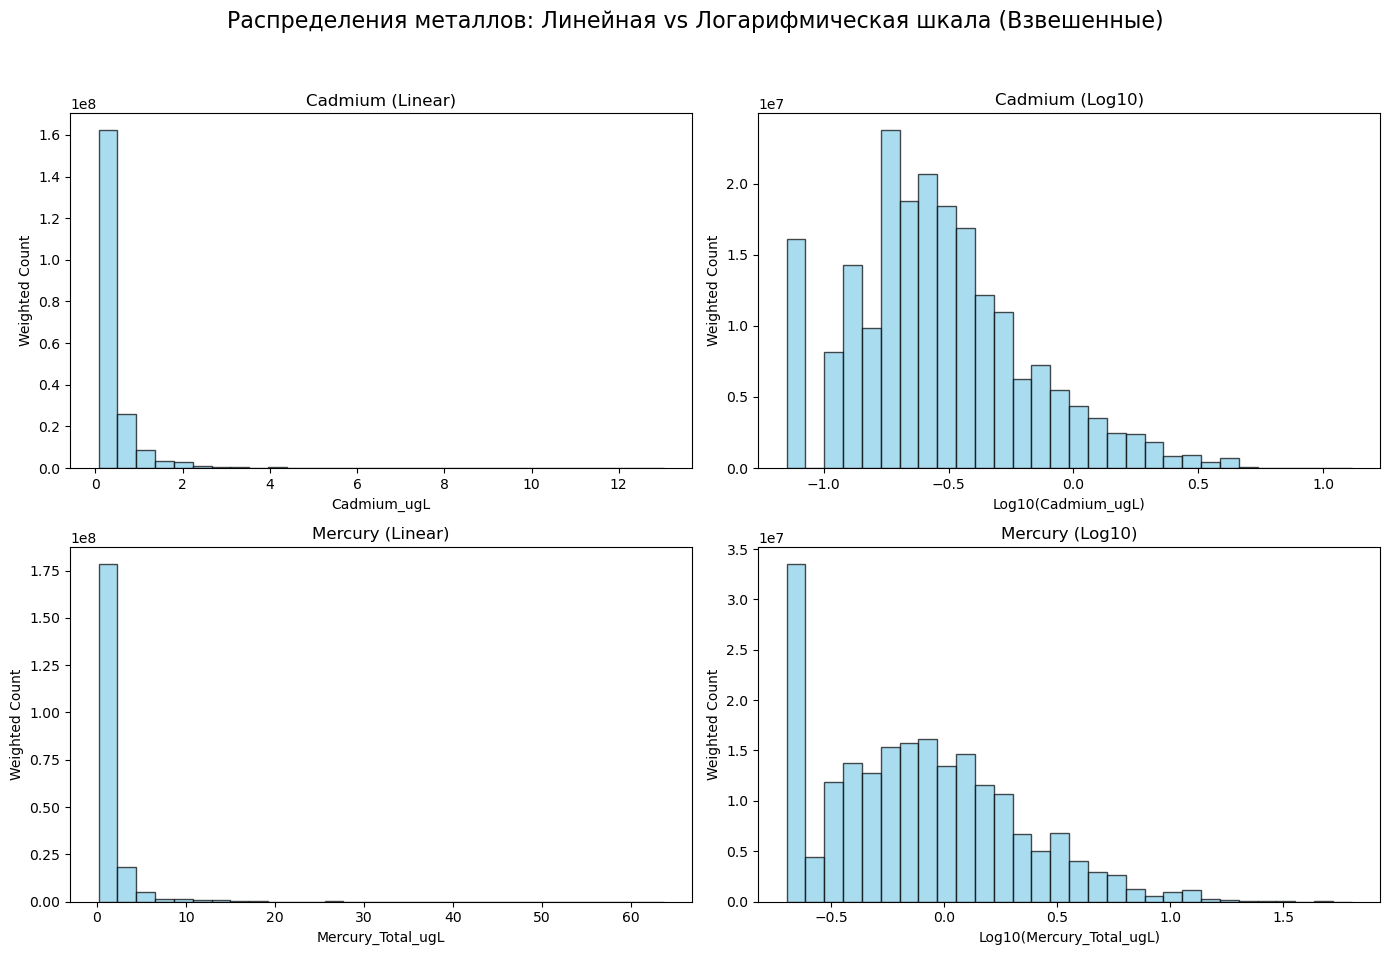

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from cleaner import clean_pipeline

df = clean_pipeline()

# Фильтрация для анализа
df_analysis = df[df["In_Analysis"] == 1].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    "Распределения металлов: Линейная vs Логарифмическая шкала (Взвешенные)",
    fontsize=16,
)


# Функция для взвешенной гистограммы
def plot_weighted_hist(data, col, weights, ax, title, log_scale=False):
    # Убираем NaN для визуализации
    mask = data[col].notna() & weights.notna()
    vals = data.loc[mask, col]
    wts = weights.loc[mask]

    if log_scale:
        # Добавляем малую константу, чтобы избежать log(0)
        vals = np.log10(vals + 0.001)
        xlabel = f"Log10({col})"
    else:
        xlabel = col

    ax.hist(vals, weights=wts, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Weighted Count")


# 1. Cadmium
plot_weighted_hist(
    df_analysis,
    "Cadmium_ugL",
    df_analysis["MEC_Weight"],
    axes[0, 0],
    "Cadmium (Linear)",
)
plot_weighted_hist(
    df_analysis,
    "Cadmium_ugL",
    df_analysis["MEC_Weight"],
    axes[0, 1],
    "Cadmium (Log10)",
    log_scale=True,
)

# 2. Mercury
plot_weighted_hist(
    df_analysis,
    "Mercury_Total_ugL",
    df_analysis["MEC_Weight"],
    axes[1, 0],
    "Mercury (Linear)",
)
plot_weighted_hist(
    df_analysis,
    "Mercury_Total_ugL",
    df_analysis["MEC_Weight"],
    axes[1, 1],
    "Mercury (Log10)",
    log_scale=True,
)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\1989915938.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=df_sub, ax=ax, palette='Set2', showfliers=False)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\1989915938.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=df_sub, ax=ax, palette='Set2', showfliers=False)
C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\1989915938.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=df_sub, ax=ax, palet

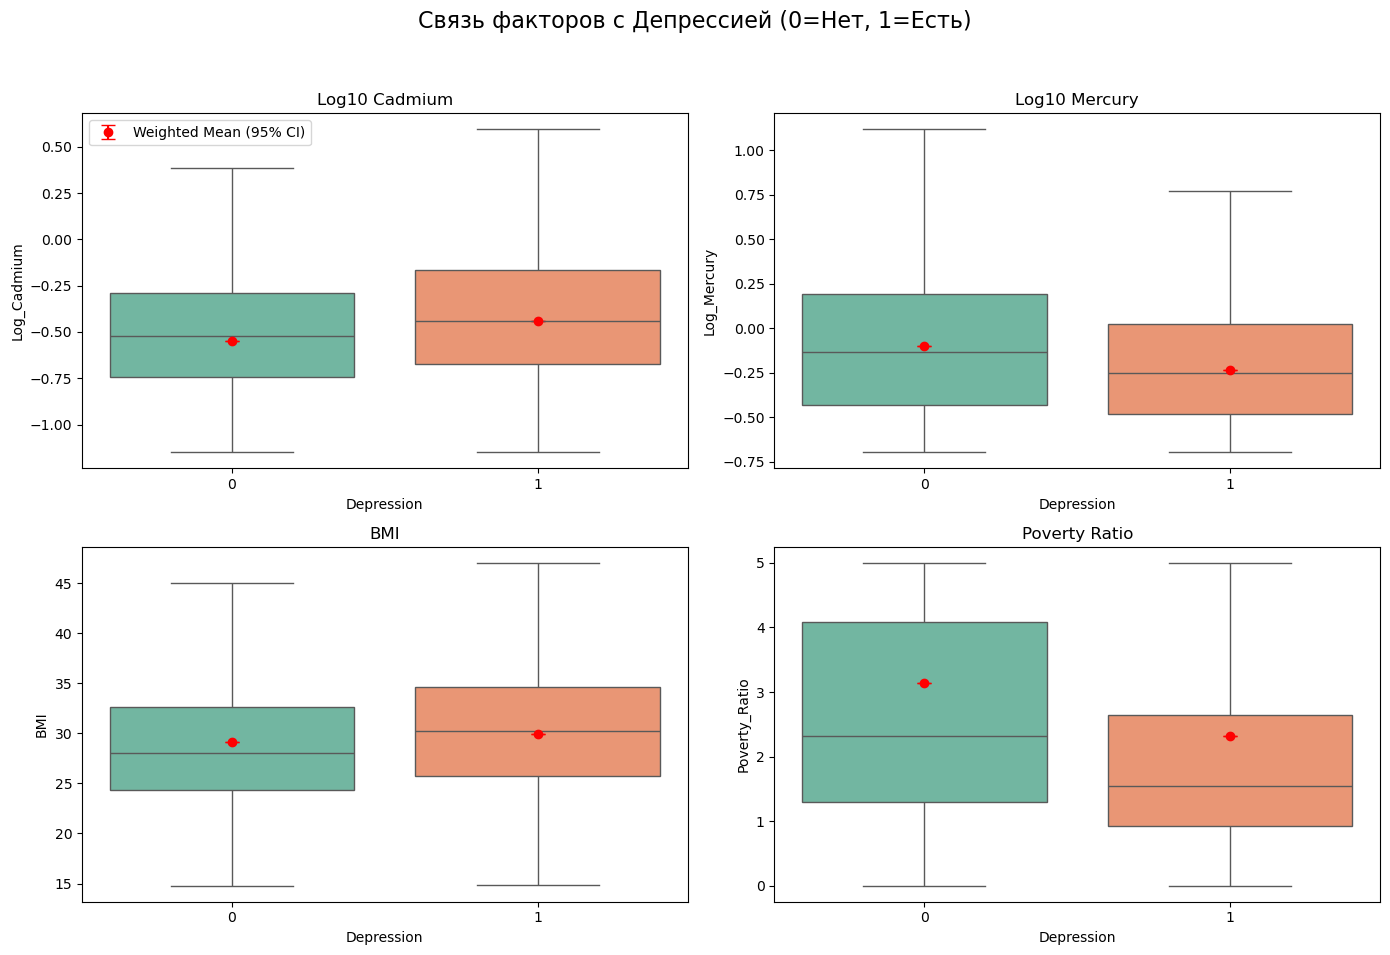

         Feature  Depression  Weighted_Mean  CI_Lower  CI_Upper
0    Log_Cadmium           0         -0.550    -0.550    -0.550
1    Log_Cadmium           1         -0.439    -0.439    -0.438
2    Log_Mercury           0         -0.103    -0.103    -0.103
3    Log_Mercury           1         -0.235    -0.235    -0.235
4            BMI           0         29.089    29.088    29.090
5            BMI           1         29.948    29.944    29.951
6  Poverty_Ratio           0          3.134     3.134     3.134
7  Poverty_Ratio           1          2.317     2.316     2.317


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

# Подготовка данных (используем только In_Analysis)
df_sub = df[df["In_Analysis"] == 1].copy()

# Создаем логарифмированные версии (с защитой от нулей)
df_sub["Log_Cadmium"] = np.log10(df_sub["Cadmium_ugL"] + 0.001)
df_sub["Log_Mercury"] = np.log10(df_sub["Mercury_Total_ugL"] + 0.001)

# Список переменных для проверки
features = ["Log_Cadmium", "Log_Mercury", "BMI", "Poverty_Ratio"]
titles = ["Log10 Cadmium", "Log10 Mercury", "BMI", "Poverty Ratio"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Связь факторов с Депрессией (0=Нет, 1=Есть)", fontsize=16)
axes = axes.flatten()

stats_summary = []

for i, col in enumerate(features):
    ax = axes[i]

    # 1. Визуализация (Seaborn boxplot для формы распределения)
    sns.boxplot(
        x="Depression", y=col, data=df_sub, ax=ax, palette="Set2", showfliers=False
    )
    ax.set_title(titles[i])

    # 2. Расчет ВЗВЕШЕННЫХ статистик (DescrStatsW)
    for dep_status in [0, 1]:
        subset = df_sub[df_sub["Depression"] == dep_status]
        # Убираем NaN для корректного расчета
        mask = subset[col].notna() & subset["MEC_Weight"].notna()

        if mask.sum() > 0:
            stats = DescrStatsW(
                subset.loc[mask, col], weights=subset.loc[mask, "MEC_Weight"]
            )
            mean_w = stats.mean
            se = stats.std_mean
            lower = mean_w - 1.96 * se
            upper = mean_w + 1.96 * se

            # Добавляем точку взвешенного среднего на график
            ax.errorbar(
                x=dep_status,
                y=mean_w,
                yerr=1.96 * se,
                fmt="o",
                color="red",
                capsize=5,
                label="Weighted Mean (95% CI)" if dep_status == 0 else "",
            )

            stats_summary.append(
                {
                    "Feature": col,
                    "Depression": dep_status,
                    "Weighted_Mean": mean_w,
                    "CI_Lower": lower,
                    "CI_Upper": upper,
                }
            )

    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Вывод таблицы для точной оценки
res_df = pd.DataFrame(stats_summary)
print(res_df.round(3))

C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\608809360.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='BMI_Category', y='Depression_Rate', data=bmi_df, ax=axes[0], palette='Blues', edgecolor='black')


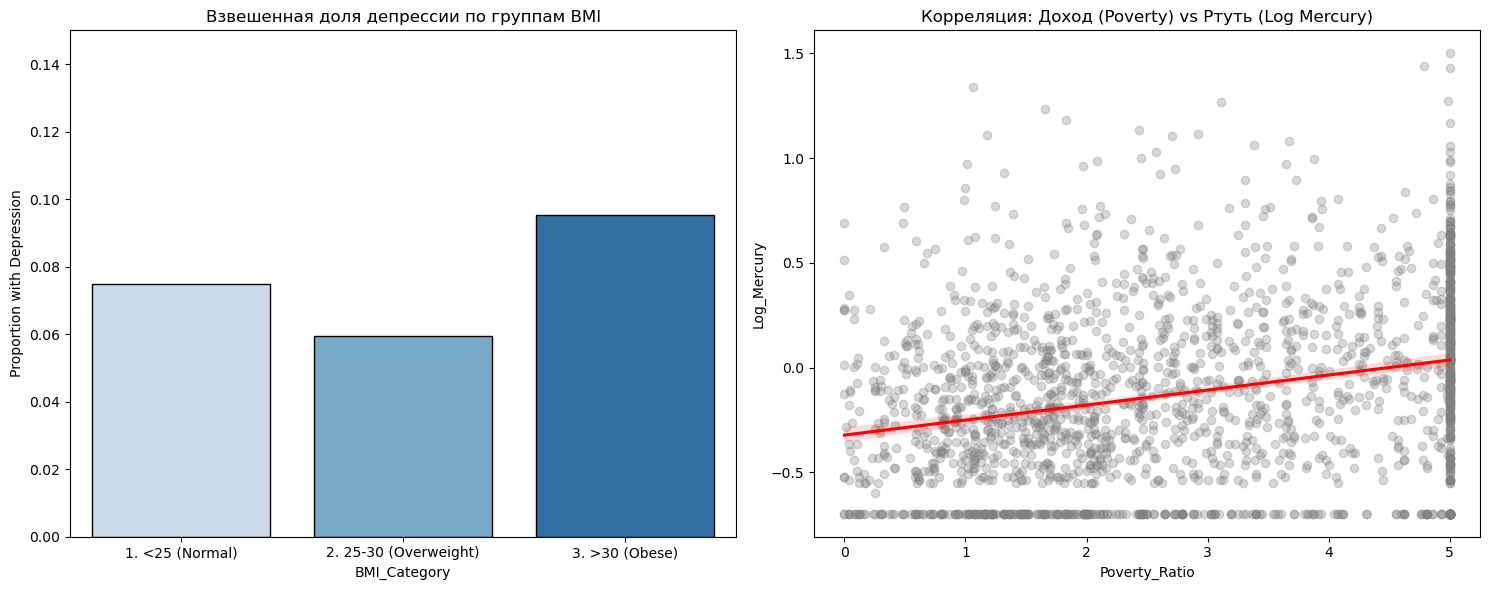

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 1. Подготовка данных
df_sub = df[df["In_Analysis"] == 1].copy()

# !!! ВОССТАНАВЛИВАЕМ ЛОГАРИФМЫ !!!
# Без этого шага 'Log_Mercury' не существует
df_sub["Log_Cadmium"] = np.log10(df_sub["Cadmium_ugL"] + 0.001)
df_sub["Log_Mercury"] = np.log10(df_sub["Mercury_Total_ugL"] + 0.001)


# 2. Категоризация BMI
def classify_bmi(bmi):
    if pd.isna(bmi):
        return None  # Обработка пропусков на всякий случай
    if bmi < 25:
        return "1. <25 (Normal)"
    elif bmi < 30:
        return "2. 25-30 (Overweight)"
    else:
        return "3. >30 (Obese)"


df_sub["BMI_Cat"] = df_sub["BMI"].apply(classify_bmi)

# 3. Подготовка данных для взвешенного барплота BMI
bmi_stats = []
# Убираем None значения перед циклом
valid_bmi_cats = df_sub["BMI_Cat"].dropna().unique()

for cat in sorted(valid_bmi_cats):
    grp = df_sub[df_sub["BMI_Cat"] == cat]
    if len(grp) > 0:
        # Взвешенное среднее для Depression (0 или 1)
        weighted_dep_rate = np.average(grp["Depression"], weights=grp["MEC_Weight"])
        bmi_stats.append({"BMI_Category": cat, "Depression_Rate": weighted_dep_rate})

bmi_df = pd.DataFrame(bmi_stats)

# 4. Визуализация
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Риск депрессии по категориям BMI
if not bmi_df.empty:
    sns.barplot(
        x="BMI_Category",
        y="Depression_Rate",
        data=bmi_df,
        ax=axes[0],
        palette="Blues",
        edgecolor="black",
    )
    axes[0].set_title("Взвешенная доля депрессии по группам BMI")
    axes[0].set_ylabel("Proportion with Depression")
    axes[0].set_ylim(0, 0.15)

# График 2: Связь Ртути и Дохода
# Используем сэмпл
sample = df_sub.sample(n=2000, random_state=42, weights=df_sub["MEC_Weight"])

# Теперь Log_Mercury точно существует
sns.regplot(
    x="Poverty_Ratio",
    y="Log_Mercury",
    data=sample,
    ax=axes[1],
    scatter_kws={"alpha": 0.3, "color": "grey"},
    line_kws={"color": "red"},
)
axes[1].set_title("Корреляция: Доход (Poverty) vs Ртуть (Log Mercury)")

plt.tight_layout()
plt.show()

C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\809048213.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


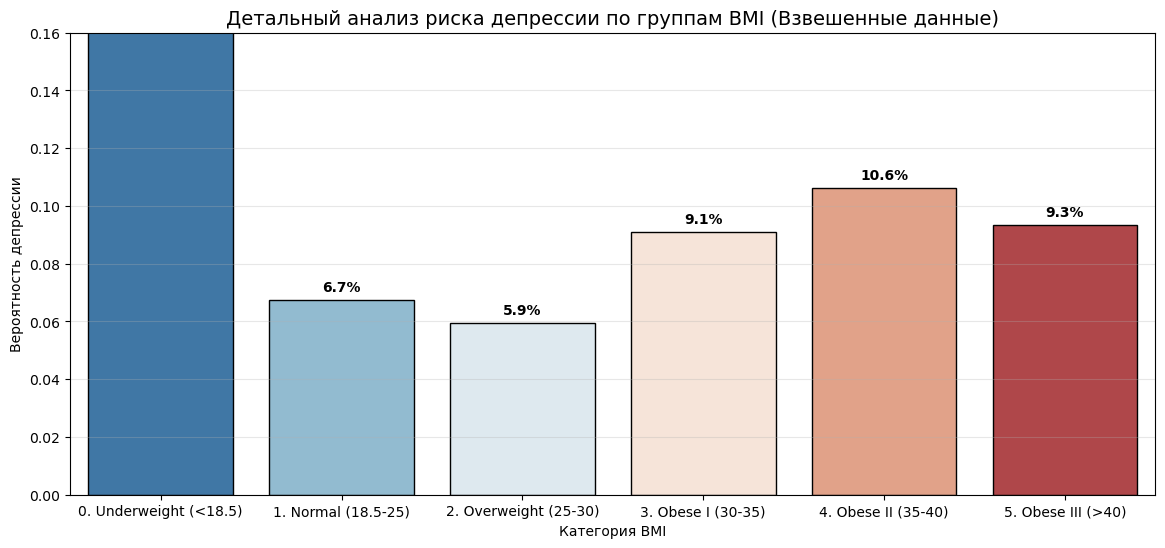

             BMI_Category  Depression_Rate  Sample_Size
0  0. Underweight (<18.5)         0.194117           81
1     1. Normal (18.5-25)         0.067413         1182
2   2. Overweight (25-30)         0.059374         1495
3      3. Obese I (30-35)         0.090977          977
4     4. Obese II (35-40)         0.106177          461
5      5. Obese III (>40)         0.093484          303


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Подготовка
df_sub = df[df["In_Analysis"] == 1].copy()


# Функция детальной классификации (WHO criteria)
def classify_bmi_detailed(bmi):
    if pd.isna(bmi):
        return None
    if bmi < 18.5:
        return "0. Underweight (<18.5)"  # Группа риска?
    elif bmi < 25:
        return "1. Normal (18.5-25)"
    elif bmi < 30:
        return "2. Overweight (25-30)"
    elif bmi < 35:
        return "3. Obese I (30-35)"
    elif bmi < 40:
        return "4. Obese II (35-40)"
    else:
        return "5. Obese III (>40)"  # Экстремальное ожирение


df_sub["BMI_Detailed"] = df_sub["BMI"].apply(classify_bmi_detailed)

# Расчет взвешенной доли депрессии
bmi_stats = []
# Сортируем категории, чтобы график был логичным
valid_cats = sorted(df_sub["BMI_Detailed"].dropna().unique())

for cat in valid_cats:
    grp = df_sub[df_sub["BMI_Detailed"] == cat]
    if len(grp) > 0:
        # Взвешенная доля
        weighted_dep = np.average(grp["Depression"], weights=grp["MEC_Weight"])
        # Добавляем также размер группы (n), чтобы понимать, надежна ли статистика
        count = len(grp)
        bmi_stats.append(
            {"BMI_Category": cat, "Depression_Rate": weighted_dep, "Sample_Size": count}
        )

bmi_df = pd.DataFrame(bmi_stats)

# Визуализация
plt.figure(figsize=(14, 6))

# Рисуем барплот
barplot = sns.barplot(
    x="BMI_Category",
    y="Depression_Rate",
    data=bmi_df,
    palette="RdBu_r",  # Красный - высокий риск, Синий - низкий (реверс)
    edgecolor="black",
)

# Добавляем подписи значений
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(
            f"{p.get_height():.1%}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
            fontweight="bold",
        )

plt.title(
    "Детальный анализ риска депрессии по группам BMI (Взвешенные данные)", fontsize=14
)
plt.ylabel("Вероятность депрессии")
plt.xlabel("Категория BMI")
plt.ylim(0, 0.16)  # Чуть выше, так как экстремумы могут быть высокими
plt.grid(axis="y", alpha=0.3)

plt.show()

# Выводим таблицу для проверки маленьких групп (например, Underweight)
print(bmi_df[["BMI_Category", "Depression_Rate", "Sample_Size"]])

C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\1042579838.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\1042579838.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\1042579838.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


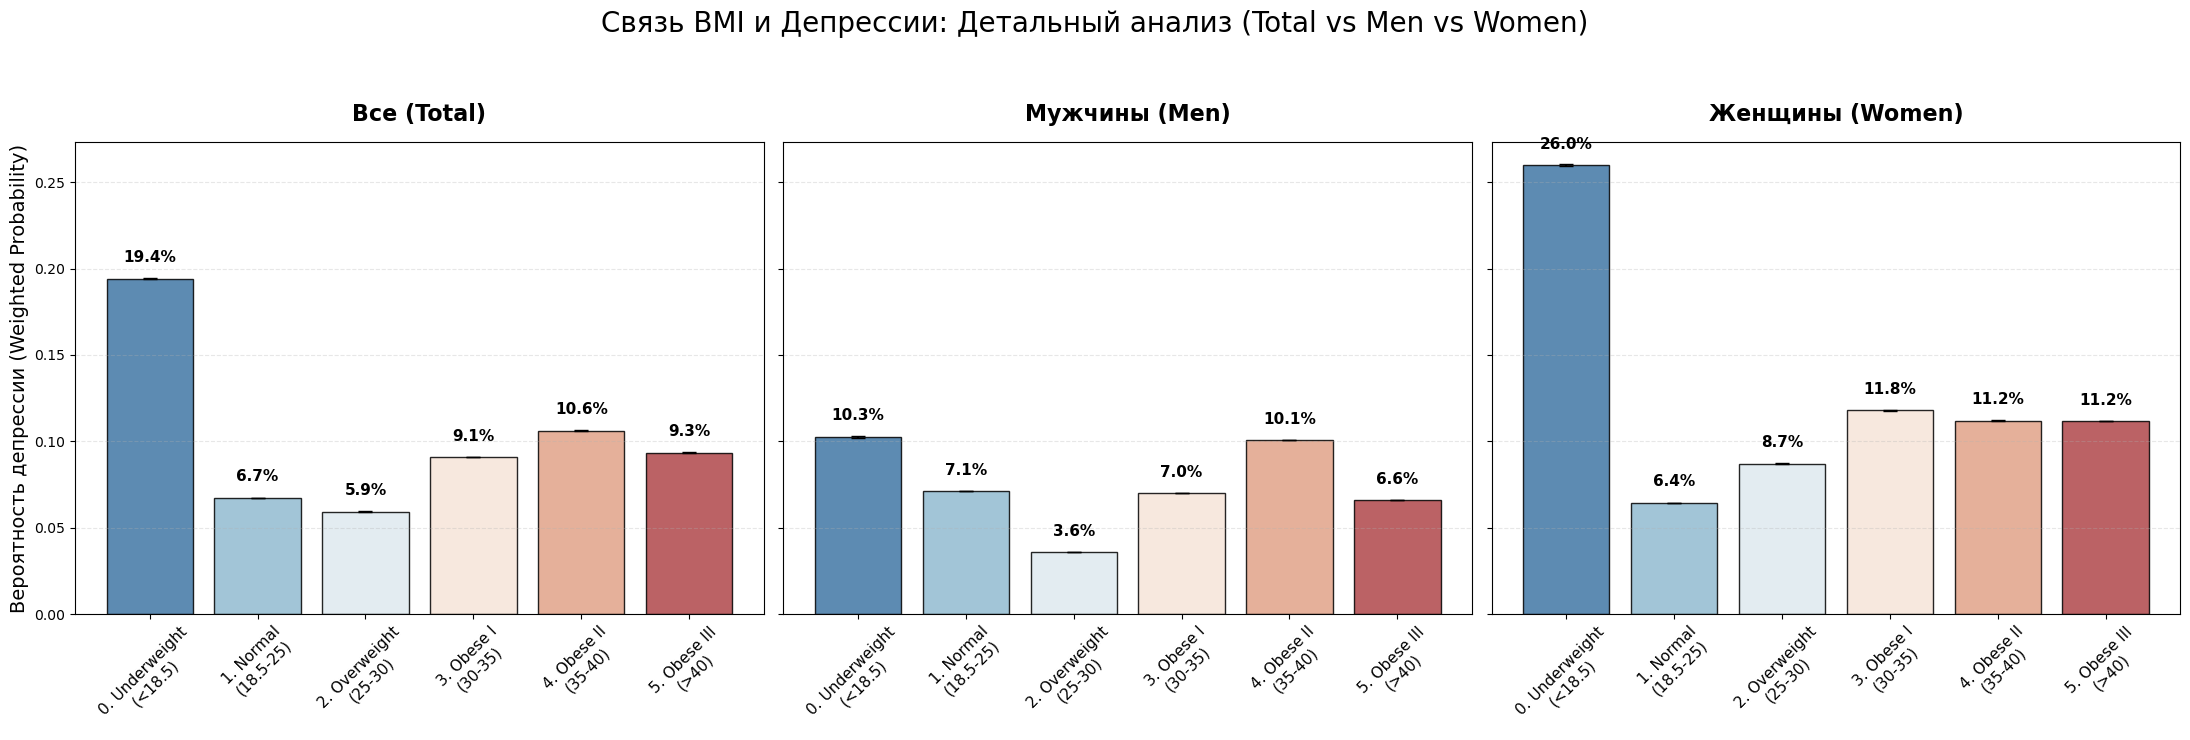

Статистика для женщин:
              BMI_Category  Depression_Rate  Sample_Size
0  0. Underweight\n(<18.5)            0.260           43
1     1. Normal\n(18.5-25)            0.064          629
2   2. Overweight\n(25-30)            0.087          670
3      3. Obese I\n(30-35)            0.118          463
4     4. Obese II\n(35-40)            0.112          237
5      5. Obese III\n(>40)            0.112          184


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

# ==========================================
# КОНФИГУРАЦИЯ (Синхронизировано с твоим файлом)
# ==========================================
GENDER_COL = "Gender"  # Имя колонки после ренейминга
BMI_COL = "BMI"  # Имя колонки BMI
WEIGHT_COL = "MEC_Weight"  # Имя колонки весов
TARGET_COL = "Depression"  # Целевая переменная

# Значения согласно твоему ENCODING_LOGIC {1: 0, 2: 1}
VAL_MALE = 0
VAL_FEMALE = 1
# ==========================================

# 1. Подготовка данных
# Убедимся, что работаем с копией, чтобы не ломать основной df
df_sub = df[df["In_Analysis"] == 1].copy()


# 2. Детальная категоризация BMI (WHO + Obese Classes)
def classify_bmi_detailed(bmi):
    if pd.isna(bmi):
        return None
    if bmi < 18.5:
        return "0. Underweight\n(<18.5)"
    elif bmi < 25:
        return "1. Normal\n(18.5-25)"
    elif bmi < 30:
        return "2. Overweight\n(25-30)"
    elif bmi < 35:
        return "3. Obese I\n(30-35)"
    elif bmi < 40:
        return "4. Obese II\n(35-40)"
    else:
        return "5. Obese III\n(>40)"


df_sub["BMI_Detailed"] = df_sub[BMI_COL].apply(classify_bmi_detailed)


# 3. Функция для расчета взвешенной доли депрессии
def get_weighted_stats(data_slice):
    stats_list = []
    # Сортируем категории, чтобы график шел по порядку
    valid_cats = sorted(data_slice["BMI_Detailed"].dropna().unique())

    for cat in valid_cats:
        grp = data_slice[data_slice["BMI_Detailed"] == cat]
        if len(grp) > 0:
            # Расчет взвешенного среднего (доля единиц в Depression)
            w_stats = DescrStatsW(grp[TARGET_COL], weights=grp[WEIGHT_COL])
            stats_list.append(
                {
                    "BMI_Category": cat,
                    "Depression_Rate": w_stats.mean,
                    "CI_Lower": w_stats.mean - 1.96 * w_stats.std_mean,  # 95% CI
                    "CI_Upper": w_stats.mean + 1.96 * w_stats.std_mean,
                    "Sample_Size": len(grp),
                }
            )
    return pd.DataFrame(stats_list)


# 4. Формируем срезы данных
slices = {
    "Все (Total)": df_sub,
    "Мужчины (Men)": df_sub[df_sub[GENDER_COL] == VAL_MALE],
    "Женщины (Women)": df_sub[df_sub[GENDER_COL] == VAL_FEMALE],
}

# 5. Визуализация (3 графика в ряд)
fig, axes = plt.subplots(1, 3, figsize=(22, 7), sharey=True)

# Цветовая палитра: от синего (низкий риск) к красному (высокий)
palette = "RdBu_r"

for ax, (title, data_slice) in zip(axes, slices.items()):
    # Считаем статистику
    plot_data = get_weighted_stats(data_slice)

    if not plot_data.empty:
        # Барплот
        barplot = sns.barplot(
            x="BMI_Category",
            y="Depression_Rate",
            data=plot_data,
            ax=ax,
            palette=palette,
            edgecolor="black",
            alpha=0.85,
        )

        # Добавляем планки погрешностей (Error Bars) вручную, т.к. seaborn их считает сам, но без весов
        # Мы используем наши предрассчитанные CI
        x_coords = range(len(plot_data))
        ax.errorbar(
            x=x_coords,
            y=plot_data["Depression_Rate"],
            yerr=[
                plot_data["Depression_Rate"] - plot_data["CI_Lower"],
                plot_data["CI_Upper"] - plot_data["Depression_Rate"],
            ],
            fmt="none",
            c="black",
            capsize=5,
        )

        # Оформление
        ax.set_title(title, fontsize=16, fontweight="bold", pad=15)
        ax.set_xlabel("")

        # Подписи процентов над столбиками
        for i, p in enumerate(barplot.patches):
            if p.get_height() > 0:
                ax.annotate(
                    f"{p.get_height():.1%}",
                    (p.get_x() + p.get_width() / 2.0, p.get_height()),
                    ha="center",
                    va="center",
                    xytext=(0, 15),
                    textcoords="offset points",
                    fontsize=11,
                    fontweight="bold",
                )

        # Сетка и оси
        ax.grid(axis="y", alpha=0.3, linestyle="--")
        ax.tick_params(axis="x", rotation=45, labelsize=11)

        if ax == axes[0]:
            ax.set_ylabel("Вероятность депрессии (Weighted Probability)", fontsize=14)
        else:
            ax.set_ylabel("")

plt.suptitle(
    "Связь BMI и Депрессии: Детальный анализ (Total vs Men vs Women)",
    fontsize=20,
    y=1.05,
)
plt.tight_layout()
plt.show()

# Выводим контрольную таблицу для Женщин (обычно самая интересная группа)
print("Статистика для женщин:")
print(
    get_weighted_stats(slices["Женщины (Women)"])[
        ["BMI_Category", "Depression_Rate", "Sample_Size"]
    ].round(3)
)

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW


# === ЧАСТЬ 1: УМНЫЙ ПОИСК ФАЙЛА ===
def find_and_load_bmx():
    filename = "BMX_J.xpt"
    # Начинаем поиск с текущей директории и идем на 2 уровня вверх, чтобы наверняка
    # (на случай, если мы глубоко в src/notebooks)
    search_roots = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]

    found_path = None

    print(f"🔍 Ищу файл '{filename}'...")

    for root in search_roots:
        # Рекурсивный поиск (rglob) файла, игнорируя регистр (если возможно)
        # Ищем точное совпадение имени
        results = list(root.rglob(filename))
        if not results:
            # Попробуем найти lowercase версию, если файл назван bmx_j.xpt
            results = list(root.rglob(filename.lower()))

        if results:
            found_path = results[0]
            print(f"✅ Файл найден: {found_path}")
            break

    if found_path:
        return pd.read_sas(found_path)
    else:
        # Если не нашли, выводим список файлов в текущей папке для отладки
        print(f"❌ Файл не найден. Текущая директория: {Path.cwd()}")
        print("Доступные файлы здесь:")
        for f in list(Path.cwd().glob("*"))[:5]:
            print(f" - {f.name}")
        raise FileNotFoundError(f"Не удалось найти {filename}. Проверьте название.")


# === ЧАСТЬ 2: АНАЛИЗ ГИПОТЕЗЫ (HUB AND SPOKE) ===

# 1. Загружаем "Спицу" (BMX данные)
try:
    df_bmx = find_and_load_bmx()
except Exception as e:
    print(e)
    # Аварийный выход, если файла нет
    df_bmx = None

if df_bmx is not None:
    # 2. Подготовка данных
    # Нам нужны только SEQN и Талия. Переименовываем сразу.
    df_waist = df_bmx[["SEQN", "BMXWAIST"]].copy()

🔍 Ищу файл 'BMX_J.xpt'...
✅ Файл найден: c:\Users\Nikita\dev\the\data\raw\exa\BMX_J.xpt


🚀 Начинаем процесс проверки гипотезы 'Fit vs Fat'...
✅ Файл найден: c:\Users\Nikita\dev\the\data\raw\exa\BMX_J.xpt
📊 Загружено записей с талией: 8704
📊 Основной датасет (In_Analysis=1): 4499 человек
🎯 Найдено мужчин в категории Overweight с данными о талии: 793

Результаты расчета:
                          Body_Type  Depression_Rate  CI_Error  Count
0  Fit / Muscular\n(Waist <= 102cm)         0.045146  0.000082    556
1     Visceral Fat\n(Waist > 102cm)         0.014922  0.000073    237


C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\254031368.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


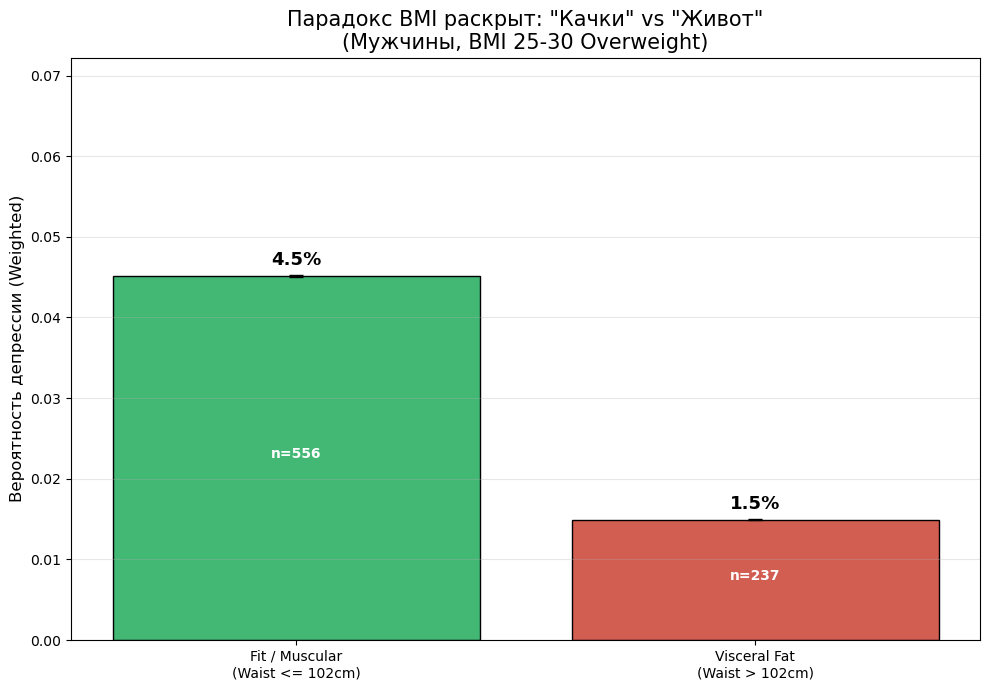

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

# === ШАГ 1: ПОИСК И ЗАГРУЗКА ФАЙЛА (Спица) ===
print("🚀 Начинаем процесс проверки гипотезы 'Fit vs Fat'...")


# Функция поиска
def load_bmx_data():
    filename = "BMX_J.xpt"
    # Ищем в текущей папке и на два уровня вверх
    search_paths = [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path.cwd() / "data" / "raw",
        Path.cwd().parent / "data" / "raw",
    ]

    found_file = None
    for path in search_paths:
        try:
            results = list(path.rglob(filename))  # Рекурсивный поиск
            if results:
                found_file = results[0]
                break
            # Попробуем строчные буквы
            results_lower = list(path.rglob(filename.lower()))
            if results_lower:
                found_file = results_lower[0]
                break
        except:
            continue

    if found_file:
        print(f"✅ Файл найден: {found_file}")
        return pd.read_sas(found_file)
    else:
        raise FileNotFoundError(
            "❌ Файл BMX_J.xpt не найден! Убедитесь, что он скачан."
        )


# Загружаем
try:
    df_bmx = load_bmx_data()
except Exception as e:
    print(e)
    df_bmx = None

# === ШАГ 2: ОБРАБОТКА И MERGE ===
if df_bmx is not None:
    # Берем только SEQN и Талию
    df_waist = df_bmx[["SEQN", "BMXWAIST"]].copy()
    df_waist.rename(columns={"BMXWAIST": "Waist_cm"}, inplace=True)

    print(f"📊 Загружено записей с талией: {len(df_waist)}")

    # Берем основной датасет (только то, что в анализе)
    df_main = df[df["In_Analysis"] == 1].copy()
    print(f"📊 Основной датасет (In_Analysis=1): {len(df_main)} человек")

    # Объединяем (Left Join)
    df_merged = df_main.merge(df_waist, on="SEQN", how="left")

    # === ШАГ 3: ФИЛЬТРАЦИЯ (КРИТИЧЕСКИЙ МОМЕНТ) ===
    # 1. Только Мужчины (Gender == 0 по твоему конфигу)
    # 2. Только Overweight (BMI >= 25 и < 30)
    # 3. Талия не пустая

    mask = (
        (df_merged["Gender"] == 0)
        & (df_merged["BMI"] >= 25)
        & (df_merged["BMI"] < 30)
        & (df_merged["Waist_cm"].notna())
    )

    df_test = df_merged[mask].copy()
    print(f"🎯 Найдено мужчин в категории Overweight с данными о талии: {len(df_test)}")

    if len(df_test) > 0:
        # === ШАГ 4: КЛАССИФИКАЦИЯ ===
        def classify_waist(row):
            # 102 см - граница абдоминального ожирения для мужчин (NCEP ATP III)
            if row["Waist_cm"] <= 102:
                return "Fit / Muscular\n(Waist <= 102cm)"
            else:
                return "Visceral Fat\n(Waist > 102cm)"

        df_test["Body_Type"] = df_test.apply(classify_waist, axis=1)

        # === ШАГ 5: РАСЧЕТ ВЗВЕШЕННОЙ СТАТИСТИКИ ===
        stats_list = []
        for btype in [
            "Fit / Muscular\n(Waist <= 102cm)",
            "Visceral Fat\n(Waist > 102cm)",
        ]:
            grp = df_test[df_test["Body_Type"] == btype]
            if len(grp) > 0:
                w_stats = DescrStatsW(grp["Depression"], weights=grp["MEC_Weight"])
                stats_list.append(
                    {
                        "Body_Type": btype,
                        "Depression_Rate": w_stats.mean,
                        "CI_Error": 1.96 * w_stats.std_mean,  # Для планок погрешности
                        "Count": len(grp),
                    }
                )

        res_df = pd.DataFrame(stats_list)
        print("\nРезультаты расчета:")
        print(res_df)

        # === ШАГ 6: ВИЗУАЛИЗАЦИЯ ===
        plt.figure(figsize=(10, 7))

        # Барплот
        barplot = sns.barplot(
            x="Body_Type",
            y="Depression_Rate",
            data=res_df,
            palette=["#2ecc71", "#e74c3c"],  # Зеленый vs Красный
            edgecolor="black",
        )

        # Планки погрешностей (Error Bars)
        # Нужно сопоставить индексы
        x_coords = range(len(res_df))
        plt.errorbar(
            x=x_coords,
            y=res_df["Depression_Rate"],
            yerr=res_df["CI_Error"],
            fmt="none",
            c="black",
            capsize=5,
        )

        plt.title(
            'Парадокс BMI раскрыт: "Качки" vs "Живот"\n(Мужчины, BMI 25-30 Overweight)',
            fontsize=15,
        )
        plt.ylabel("Вероятность депрессии (Weighted)", fontsize=12)
        plt.xlabel("")
        plt.ylim(0, res_df["Depression_Rate"].max() * 1.6)  # Запас сверху для подписей

        # Подписи процентов
        for p in barplot.patches:
            if p.get_height() > 0:
                plt.annotate(
                    f"{p.get_height():.1%}",
                    (p.get_x() + p.get_width() / 2.0, p.get_height()),
                    ha="center",
                    va="bottom",
                    xytext=(0, 5),
                    textcoords="offset points",
                    fontweight="bold",
                    fontsize=13,
                )

        # Добавляем подпись про N (размер выборки) внутрь столбиков
        for i, row in res_df.iterrows():
            plt.text(
                i,
                row["Depression_Rate"] / 2,
                f"n={int(row['Count'])}",
                ha="center",
                color="white",
                fontweight="bold",
            )

        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ Внимание: После фильтрации таблица пуста. Проверьте:")
        print("1. Есть ли мужчины (Gender=0)?")
        print("2. Есть ли BMI в диапазоне 25-30?")
else:
    print("❌ Не удалось загрузить вспомогательные данные.")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

# Используем тот же df_test, который мы создали ранее (Мужчины, BMI 25-30)
# Если переменная потерялась, скажи, я дам код восстановления.

print("🧪 Контрольный эксперимент: Убираем фактор возраста...")

# ФИЛЬТР: Берем только мужчин от 20 до 50 лет
# Это уберет "счастливых пенсионеров" из красной группы
mask_young = df_test["Age"] <= 50
df_young = df_test[mask_young].copy()

print(f"Осталось мужчин в возрасте 20-50 лет: {len(df_young)}")

# Пересчитываем статистику для этой молодой группы
stats = []
for btype in ["Fit / Muscular\n(Waist <= 102)", "Visceral Fat\n(Waist > 102)"]:
    grp = df_young[df_young["Body_Type"] == btype]
    if len(grp) > 0:
        w_stats = DescrStatsW(grp["Depression"], weights=grp["MEC_Weight"])
        stats.append(
            {"Body_Type": btype, "Depression_Rate": w_stats.mean, "Count": len(grp)}
        )

res_young = pd.DataFrame(stats)

# Визуализация
plt.figure(figsize=(8, 6))
barplot = sns.barplot(
    x="Body_Type",
    y="Depression_Rate",
    data=res_young,
    palette=["#2ecc71", "#e74c3c"],
    edgecolor="black",
)

plt.title(
    "Чистый эффект талии (Только мужчины 20-50 лет)\nBMI 25-30 (Overweight)",
    fontsize=14,
)
plt.ylabel("Вероятность депрессии")
plt.xlabel("")

# Подписи
for p in barplot.patches:
    if p.get_height() > 0:
        plt.annotate(
            f"{p.get_height():.1%}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=12,
            fontweight="bold",
        )

# Добавляем N
for i, row in res_young.iterrows():
    plt.text(
        i,
        row["Depression_Rate"] / 2,
        f"n={int(row['Count'])}",
        ha="center",
        color="white",
        fontweight="bold",
    )

plt.ylim(0, 0.10)  # Масштаб побольше, так как у молодых депрессия выше
plt.grid(axis="y", alpha=0.3)
plt.show()

print(res_young)

🧪 Контрольный эксперимент: Убираем фактор возраста...
Осталось мужчин в возрасте 20-50 лет: 353


ValueError: Could not interpret value `Body_Type` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

🔄 Пересборка данных для финальной проверки...
👥 Найдено мужчин 20-50 лет (Overweight): 322


C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\2469389790.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Body_Type', y='Depression_Rate', data=res_young,


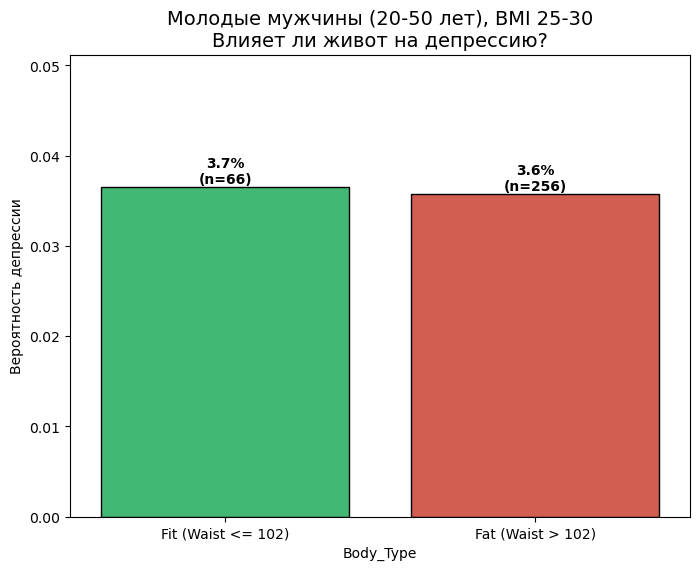

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

# 1. Повторная сборка данных (чтобы не зависеть от прошлых ячеек)
print("🔄 Пересборка данных для финальной проверки...")


# Ищем файл BMX
def find_bmx():
    for path in [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]:
        found = list(path.rglob("*BMX_J.xpt"))
        if found:
            return pd.read_sas(found[0])
    return None


df_bmx = find_bmx()

if df_bmx is not None:
    # Готовим данные талии
    df_waist = df_bmx[["SEQN", "BMXWAIST"]].copy()
    df_waist.rename(columns={"BMXWAIST": "Waist_cm"}, inplace=True)

    # Мержим с основной таблицей
    df_main = df[df["In_Analysis"] == 1].copy()  # Твой основной DF
    df_merged = df_main.merge(df_waist, on="SEQN", how="left")

    # 2. ЖЕСТКИЙ ФИЛЬТР: Мужчины (0), Overweight (25-30), Возраст (20-50)
    # Убираем стариков, чтобы проверить гипотезу "Счастливого Деда"
    mask_target = (
        (df_merged["Gender"] == 0)
        & (df_merged["BMI"] >= 25)
        & (df_merged["BMI"] < 30)
        & (df_merged["Age"] >= 20)
        & (df_merged["Age"] <= 50)  # <--- ВОТ ОНО
        & (df_merged["Waist_cm"].notna())
    )

    df_young = df_merged[mask_target].copy()
    print(f"👥 Найдено мужчин 20-50 лет (Overweight): {len(df_young)}")

    if not df_young.empty:
        # Классификация
        df_young["Body_Type"] = df_young["Waist_cm"].apply(
            lambda x: "Fit (Waist <= 102)" if x <= 90 else "Fat (Waist > 102)"
        )

        # Расчет
        stats = []
        for btype in ["Fit (Waist <= 102)", "Fat (Waist > 102)"]:
            grp = df_young[df_young["Body_Type"] == btype]
            if len(grp) > 0:
                w_stats = DescrStatsW(grp["Depression"], weights=grp["MEC_Weight"])
                stats.append(
                    {
                        "Body_Type": btype,
                        "Depression_Rate": w_stats.mean,
                        "Count": len(grp),
                    }
                )

        res_young = pd.DataFrame(stats)

        # 3. Визуализация (только если есть результаты)
        if not res_young.empty:
            plt.figure(figsize=(8, 6))
            sns.barplot(
                x="Body_Type",
                y="Depression_Rate",
                data=res_young,
                palette=["#2ecc71", "#e74c3c"],
                edgecolor="black",
            )

            plt.title(
                "Молодые мужчины (20-50 лет), BMI 25-30\nВлияет ли живот на депрессию?",
                fontsize=14,
            )
            plt.ylabel("Вероятность депрессии")

            # Подписи
            for i, row in res_young.iterrows():
                plt.text(
                    i,
                    row["Depression_Rate"],
                    f"{row['Depression_Rate']:.1%}\n(n={int(row['Count'])})",
                    ha="center",
                    va="bottom",
                    fontweight="bold",
                )

            plt.ylim(0, res_young["Depression_Rate"].max() * 1.4)
            plt.show()
        else:
            print("⚠️ Данные есть, но после группировки таблица пуста.")
    else:
        print(
            "❌ В выборке нет людей, подходящих под условия (Мужчины 20-50 лет, BMI 25-30)."
        )
else:
    print("❌ Не найден файл BMX_J.xpt")

🚀 Финальный аккорд по теме Веса: DXA + Умная Талия...
✅ НАЙДЕНЫ ДАННЫЕ DXA! Переходим на уровень 'Бог Аналитики'.


C:\Users\Nikita\AppData\Local\Temp\ipykernel_21508\646394459.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Rate', data=res_dxa, palette='viridis', edgecolor='black')


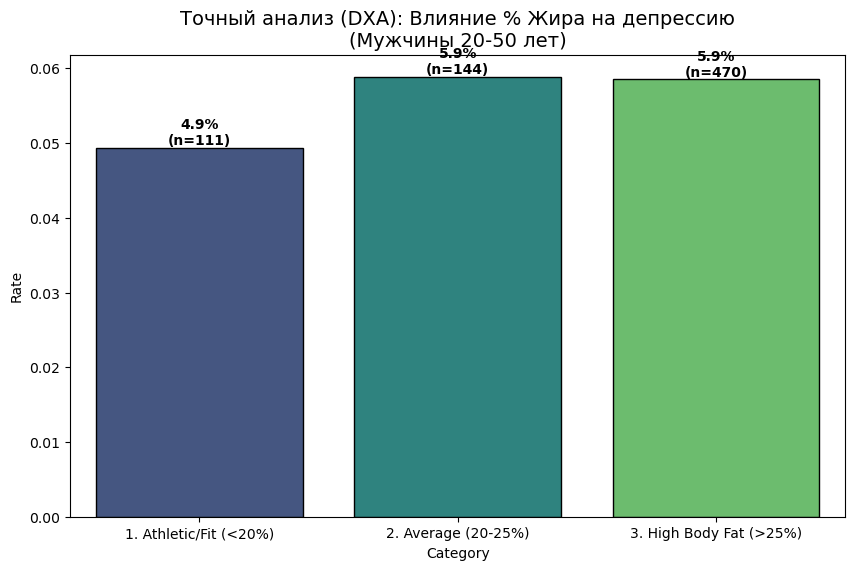

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

print("🚀 Финальный аккорд по теме Веса: DXA + Умная Талия...")


# === ФУНКЦИЯ ПОИСКА ФАЙЛОВ ===
def find_file(pattern):
    for path in [
        Path.cwd(),
        Path.cwd().parent,
        Path.cwd().parent.parent,
        Path.cwd() / "data" / "raw",
        Path.cwd().parent / "data" / "raw",
    ]:
        found = list(path.rglob(pattern))
        if found:
            return pd.read_sas(found[0])
    return None


# 1. Загружаем данные
df_bmx = find_file("*BMX_J.xpt")  # Талия
df_dxa = find_file("*DXX_J.xpt")  # Рентген (Если есть)

# Основной DF
df_main = df[df["In_Analysis"] == 1].copy()

# === ВЕТКА А: ЕСЛИ ЕСТЬ DXA (ЗОЛОТОЙ СТАНДАРТ) ===
if df_dxa is not None:
    print("✅ НАЙДЕНЫ ДАННЫЕ DXA! Переходим на уровень 'Бог Аналитики'.")

    # Берем Процент Жира (DXDTOPF)
    # DXDTOPF: Total Percent Fat
    dxa_cols = df_dxa[["SEQN", "DXDTOPF"]].copy()
    dxa_cols.rename(columns={"DXDTOPF": "Body_Fat_Pct"}, inplace=True)

    # Мержим
    df_merged = df_main.merge(
        dxa_cols, on="SEQN", how="inner"
    )  # Inner - только те, у кого был рентген

    # Фильтр: Мужчины 20-50
    mask = (
        (df_merged["Gender"] == 0) & (df_merged["Age"] >= 20) & (df_merged["Age"] <= 50)
    )
    df_target = df_merged[mask].copy()

    # Категории по % жира (для мужчин)
    # < 20% = Атлет/Фит
    # > 25% = Ожирение (по стандартам American Council on Exercise)
    def classify_fat(pct):
        if pd.isna(pct):
            return None
        if pct < 20:
            return "1. Athletic/Fit (<20%)"
        elif pct < 25:
            return "2. Average (20-25%)"
        else:
            return "3. High Body Fat (>25%)"

    df_target["Fat_Category"] = df_target["Body_Fat_Pct"].apply(classify_fat)

    # Визуализация
    plt.figure(figsize=(10, 6))

    # Считаем взвешенное
    stats = []
    for cat in sorted(df_target["Fat_Category"].dropna().unique()):
        grp = df_target[df_target["Fat_Category"] == cat]
        if len(grp) > 0:
            w_mean = DescrStatsW(grp["Depression"], weights=grp["MEC_Weight"]).mean
            stats.append({"Category": cat, "Rate": w_mean, "N": len(grp)})

    res_dxa = pd.DataFrame(stats)

    sns.barplot(
        x="Category", y="Rate", data=res_dxa, palette="viridis", edgecolor="black"
    )
    plt.title(
        "Точный анализ (DXA): Влияние % Жира на депрессию\n(Мужчины 20-50 лет)",
        fontsize=14,
    )

    for i, row in res_dxa.iterrows():
        plt.text(
            i,
            row["Rate"],
            f"{row['Rate']:.1%}\n(n={row['N']})",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    plt.show()

# === ВЕТКА Б: ЕСЛИ НЕТ DXA (ИСПОЛЬЗУЕМ ТАЛИЮ С ПОРОГОМ 94) ===
else:
    print("⚠️ Файл DXX_J.xpt не найден. Используем улучшенный анализ талии.")

    if df_bmx is not None:
        df_waist = df_bmx[["SEQN", "BMXWAIST"]].copy()
        df_merged = df_main.merge(
            df_waist.rename(columns={"BMXWAIST": "Waist"}), on="SEQN", how="left"
        )

        # Фильтр: Мужчины 20-50, BMI 25-30
        mask = (
            (df_merged["Gender"] == 0)
            & (df_merged["Age"] >= 20)
            & (df_merged["Age"] <= 50)
            & (df_merged["BMI"] >= 25)
            & (df_merged["BMI"] < 30)
        )

        df_target = df_merged[mask].copy()

        # === ИСПРАВЛЕНИЕ: ПОРОГ 94 СМ (Euro-standard) ===
        # Это перекинет часть людей из "Fit" в "Fat" и сбалансирует выборку
        thresh = 94

        df_target["Body_Type"] = df_target["Waist"].apply(
            lambda x: f"Fit (Waist < {thresh})"
            if x < thresh
            else f"Fat (Waist >= {thresh})"
        )

        # Считаем
        stats = []
        for cat in [f"Fit (Waist < {thresh})", f"Fat (Waist >= {thresh})"]:
            grp = df_target[df_target["Body_Type"] == cat]
            if len(grp) > 0:
                w_mean = DescrStatsW(grp["Depression"], weights=grp["MEC_Weight"]).mean
                stats.append({"Body_Type": cat, "Rate": w_mean, "N": len(grp)})

        res_waist = pd.DataFrame(stats)

        plt.figure(figsize=(8, 6))
        sns.barplot(
            x="Body_Type",
            y="Rate",
            data=res_waist,
            palette=["#2ecc71", "#e74c3c"],
            edgecolor="black",
        )
        plt.title(
            f"Влияние талии (Порог {thresh}см)\nМужчины 20-50, BMI 25-30", fontsize=14
        )

        for i, row in res_waist.iterrows():
            plt.text(
                i,
                row["Rate"],
                f"{row['Rate']:.1%}\n(n={row['N']})",
                ha="center",
                va="bottom",
                fontweight="bold",
            )

        plt.ylim(0, max(res_waist["Rate"]) * 1.5)
        plt.show()